16.512, Homework 3, Johannes Norheim, 9/29

This pset was written in a jupyter notebooks, and has been uploaded online to https://github.com/norheim/rocketscience/blob/master/hw3.ipynb

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve, minimize
import matplotlib.pyplot as plt

## $\Delta V$ budget

We will consider the mission in stages guided by the Delta II user guide: launch, circular parking orbit at 185km, and then hohmann transfer to lunar distance, lunar orbit insertion and cicularization. 

Lunar orbit is 5.14° off the orbit of the Earth around the sun, which is then again tilted by 23.44° with respect to the equator(more on https://en.wikipedia.org/wiki/Orbit_of_the_Moon). 

For simplicity, we will ignore this, and assume the 30° mentioned in the problem, and interpret the geometry of the problem as outlined in the following picture, which makes sure we enter a polar orbit in the plane tangent to the trajectory of the moon's orbit around the earth:

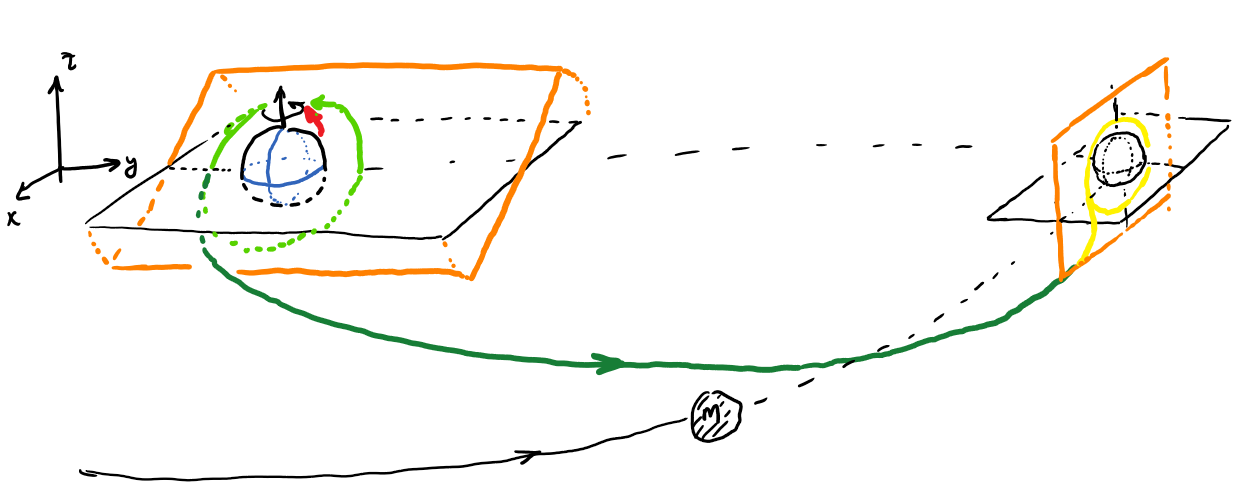

|   Top view  | Lunar view|
|------|------|
| ![hohman.png](hohman.png) | ![lunarorbit.png](lunarorbit.png) |

### Launch

Delta IIs launch from Cape Canaveral Florida at 28° 24' 20" N. We will assume we can easily adjust the flight azimuth to achieve an inclination of 30° for the first circular orbit. To estimate the $\Delta v$ required for launch let's add 

1. orbital velocity in parking orbit(185km) and 
2. gravity losses (and neglect drag losses), and 
3. calculate and subtract free $\Delta v$ from the rotation of the Earth

In [2]:
mu_earth = 3.986e14
r_earth = 6378.1e3

parking_h = 185e3
dv_1 = np.sqrt(mu_earth/(r_earth+parking_h)) # it's ok to set delta-v to the ciruclar orbit since it's very low
dv_2 = 822 #m/s
print 'delta_v1 = %f m/s'%dv_1, 'delta_v2 = %s m/s'%dv_2

delta_v1 = 7793.169756 m/s delta_v2 = 822 m/s


Rotation velocity will actually require a little extra analysis:

$v_r = \Omega_E R_E cos\lambda $

$v_3 = \sqrt{v_r^2+\Delta v_1^2+2 v_r \Delta v_1 cos\beta} $

Where $\beta$ is related to the launch azimuth $\gamma$ by:

$ tan\gamma = \frac{\Delta v_1 sin\beta}{v_r + \Delta v_1 cos\beta} $

the angle required to get into an inclination of $i=30°$, which we can get from the following calculation:

$ cos(i) = cos\gamma \cdot cos\lambda$


In [3]:
omega_earth = 2*np.pi/(24*3600) # earth rotational speed
lat_launch = np.radians(28 + 24./60 + 20./3600)
v_r = np.cos(lat_launch)*r_earth*omega_earth
i = np.radians(30)
gamma = np.arccos(np.cos(i)/np.cos(lat_launch))
beta = fsolve(lambda beta: np.tan(gamma)-dv_1*np.sin(beta)/(v_r+dv_1*np.cos(beta)), 0)
dv_3 = np.sqrt(v_r**2+dv_1**2+2*v_r*dv_1*np.cos(beta))-dv_1
print 'delta_v3 = %f m/s'%dv_3

delta_v3 = 401.360140 m/s


Adding all up:

In [4]:
dv_launch = dv_1+dv_2-dv_3

In [5]:
print 'dv_launch %f m/s'%dv_launch 

dv_launch 8213.809616 m/s


### Hohman transfer

To transfer to the moon, we need to send ourselves into an elliptical orbit with periapsis at h=185km, and apoapsis the distance to the moon (about 384,400km). This will require a $\Delta v_{transfer}$:

In [6]:
rp = r_earth + parking_h
r_moon = 384400e3
ra = r_moon

vp_hm = np.sqrt(2*mu_earth*ra/(rp*(ra+rp)))
vc = np.sqrt(mu_earth/rp)
dv_transfer = vp_hm-vc
dv_takeoff = dv_launch+dv_transfer
print 'dv_transfer %f m/s'%dv_transfer
print 'dv_takeoff %f m/s'%dv_takeoff

dv_transfer 3135.138557 m/s
dv_takeoff 11348.948173 m/s


### Lunar capture

Once we get to the moon things get interesting, since both the moon and the spacecraft are moving. To clarify, here is the overview of the geometry again:
![lunarorbit.png](lunarorbit.png) 

The tricky part is that the moon is not static, but also moving (which is why it is dotted out in the drawing), so let's change things into the reference frame on the moon. From this point of view, the velocity of the spacecraft is: $v_{apogee} - v_{moon}$, which are both vector quantities. We can add them up to get the total velocity:

In [7]:
va_hm = np.sqrt(2*mu_earth*rp/(ra*(ra+rp))) # apogee velocity
v_moon = np.sqrt(mu_earth/r_moon)

v_infty = np.sqrt((va_hm*np.cos(i)+v_moon)**2+(va_hm*np.sin(i))**2)
v_infty

1183.5734318048787

Assuming this to be $v_\infty$, we can get the velocity at lunar altitude of $h_{moon}=50km$

In [8]:
h_moon = 50e3
mu_moon = 4.903e12
v_moonorb = np.sqrt(v_infty**2+2*mu_moon/(r_moon+h_moon))
v_moonorb

1194.3000612486555

We want to be in lunar orbit $v_{cm} = \sqrt{\frac{\mu_{moon}}{r_{moon}+h_{moon}}} $

In [9]:
v_cm = np.sqrt(mu_moon/(r_moon+h_moon))
v_cm

112.9304383772692

Hence the $\Delta v $ required is:

In [10]:
dv_capture = v_moonorb-v_cm
dv_capture #m/s

1081.3696228713864

### Stage burn sequencing

Before we look at how much $ \Delta v $ we can get out of the Delta II, let's just note that we will assume that the liquide engine, all the boosters and the second stage will secure the $ \Delta v_{launch} + \Delta v_{transfer}$ and the third stage $ \Delta v_{capture}$

## Delta-II available $\Delta V$

The goal of this section is to add up the amount of $\Delta v$ from the launch as a function of payload mass, and find the maximum payload mass for which we can get:

* $\Delta v_{launch}+\Delta v_{transfer}  = 11349m/s$
* $\Delta v_{capture} = 1081m/s$

To get to the $\Delta v$ for each of these stages we will need to add up the $\Delta v_i$ of each rocket component during each stage, and since the Delta II has a fair amount of complexity in the staging we will make our lives easier by setting up some helper functions to calculate it for us. But first, let's gather the data we will need for the Delta II 7925-10, from the User Guide:

|Component | Section | Number | Ignition | Cut-off | Separation | Force | Total mass | Fuel mass | Note |
|----------|--------||--------|----------|---------|------------|-------|------------|-----------|------|
|Booster   |Launch| 6      | 0s       |      63s| 66s         |446kN | 13,232kg   | 11,765kg  |   |
|Booster   |Launch| 3      | 68s      |     129s| 132s       |446kN | 13,061kg   | 11,765kg  ||
|Liquid first stage |Launch| 1 | 0s   | 260.5s (MECO)   | MECO + 8s      | 890kN |101,718kg   | 96,033kg  ||
|Liquid second stage |Launch + Transfer| 1 | MECO + 13.5s  | MECO + 356s    |SECO + 53s |43.37kN | 6,930kg   | 6,006kg  |Fires a second time for 70s (SECO) |
|Fairing | Launch |1 |  | | MECO + 39s | |839kg||
|Third stage | Capture| 1 | SECO + 89 | SECO + 177 | SECO + 290 | 66.43kN | 2,141kg | 2,025kg |
|Payload || 1 | | | | |$M_L$ | | to be calculated |


*However, as noted by the problem, fuel masses can be reduced down to 20%. The only advantage of this is that by reducing the mass of upper stages, we can get more $\Delta v$ out of the lower stages (but less $\Delta v$ overall)*

Next we will create a helper object to store all this information, and allow us to run calculations on it. Note that most functions are specific to propulsive components, but that it still allows us to store info for the non-propulsive components. We can use this to calculate properties such as Isp and exhaust velocity. 

We assume constant mass flow for all propulsive stages, and constant force throughout the burn time, and we use this to calculate the Isp and exhaust velocity:
$c = \frac{F}{\dot{m}} , \ \dot{m} = \frac{m_{fuel}}{\Delta t_{burn}}, \ Isp = \frac{c}{9.81}$

In [11]:
class RocketComponent(object):
    def __init__(self, name, t, F, mtotal, mfuel, mstruct=None, isp=None):
        self.F = F
        self.mtotal = mtotal if mstruct == None else mstruct+mfuel
        self.mfuel = mfuel
        self.mstruct = mtotal-mfuel if mstruct == None else mstruct
        self.isp = self.calc_isp(t) if isp == None else isp
        self.c = self.isp*9.81
        self.t = t if isp == None else (t[0], self.calc_burnout(t), t[2])
        self.deltat = t[1]-t[0]
        self.name = name
    
    def calc_isp(self, t):
        if self.mfuel != 0:
            deltat = t[1]-t[0]
            isp = self.F*deltat/(self.mfuel*9.81)
        else:
            isp = 0
        return isp
    
    def calc_burnout(self, t):
        deltat = self.c*self.mfuel/self.F
        return t[0]+deltat
        
    def mass(self, t):
        fire, cutoff, separation = self.t
        return np.piecewise(t, [t<=separation, t>separation],
                     [lambda t: np.interp(t, [fire, cutoff], [self.mtotal, self.mstruct]),
                     0])
    
    def firing(self, t):
        fire, cutoff, _ = self.t
        return np.piecewise(t, [t<=fire, (t>fire) & (t<= cutoff), t>cutoff], [0, 1, 0])
    
    def __repr__(self):
        return self.name

Let's now instantiate all the Delta-II components, with 100% fuel:

In [12]:
# First stage
booster6 = RocketComponent('booster6', [0, 63, 66], 6*446e3, 6*13232, 6*11765)
booster3 = RocketComponent('booster3', [68, 129, 132], 3*446e3, 3*13061, 3*11765)
meco = 260.5
liq = RocketComponent('liq', [0, meco, meco+8], 890e3, 101718, 96033)
# Second stage
seco = meco+356+689
stage2 = RocketComponent('stage2', [meco + 13.5, meco+356+70, seco+53], 43.37e3, 6930, 6006)
fairing = RocketComponent('fairing', [meco + 19, meco + 19, meco + 19], 0, 839, 0)
#Third stage
stage3 = RocketComponent('stage3', [seco+89, seco+177, seco+290], 66.4e3, 2141, 2025)
demo_payload = RocketComponent('payload', [seco+290, seco+290, seco+290], 0, 5000, 0) # for initial calculations

We can see the constant mass flow assumption if we plot the mass of the boosters over time, and then the separation for example:

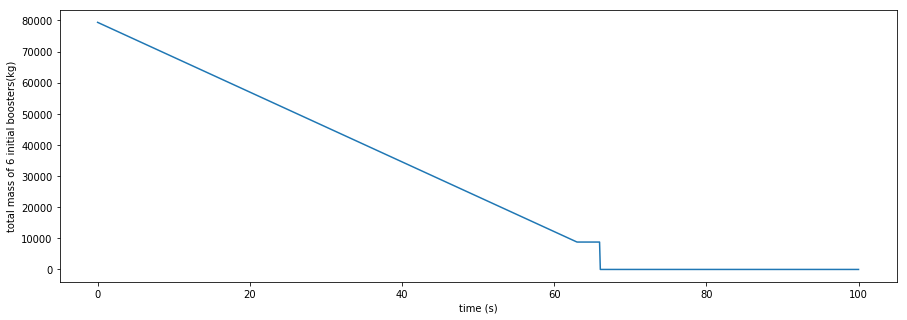

In [13]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, 100, 1000), booster6.mass(np.linspace(0, 100, 1000)))
plt.xlabel('time (s)')
plt.ylabel('total mass of 6 initial boosters(kg)')
plt.show()

To add up all the stages, and calculate the $\Delta v$ let's create a second helper object:

In [14]:
class Rocket(object):
    def __init__(self, stages):
        self.stages = stages
    
    def mass(self, t):
        return np.sum(np.array([stage.mass(t) for stage in self.stages]), axis=0)
    
    def sequences(self):
        times = list(set([t for stage in self.stages for t in stage.t]))
        times.sort()
        seq = []
        for i in range(len(times)-1):
            t0, t1 = times[i], times[i+1]
            firing = [stage for stage in self.stages if stage.firing(t1)]
            separation = [stage for stage in self.stages if stage.t[2] == t1]
            seq.append(dict(fire=t0, cutoff=t1, stages=firing, separation=separation)) 
        return pd.DataFrame.from_dict(seq)     
    
    def deltav(self, cfunc):
        seq = self.sequences()
        startmass = self.mass(np.array(seq["fire"]))
        endmass = self.mass(np.array(seq["cutoff"]))
        dvs = seq["stages"].apply(cfunc)*np.log(startmass/endmass)
        seq["m_i"] = startmass
        seq["m_i+1"] = endmass
        seq["deltav"] = dvs
        return seq

In [15]:
delta2 = Rocket([booster6, booster3, liq, stage2, fairing, stage3, demo_payload])

The rocket has a function called sequences, which takes all the components, and figures out the time sections that we get from the firing, cutoff and separation of each of the components over time:

In [16]:
delta2.sequences()[["fire", "cutoff", "stages", "separation"]]

,fire,cutoff,stages,separation
0,0.0,63.0,"[booster6, liq]",[]
1,63.0,66.0,[liq],[booster6]
2,66.0,68.0,[liq],[]
3,68.0,129.0,"[booster3, liq]",[]
4,129.0,132.0,[liq],[booster3]
5,132.0,260.5,[liq],[]
6,260.5,268.5,[],[liq]
7,268.5,274.0,[],[]
8,274.0,279.5,[stage2],[fairing]
9,279.5,686.5,[stage2],[]


To get the $\Delta v$ from each time-frame, we only have to apply the rocket equation between $t_{fire}$ and $t_{cutoff}$ for that time-frame, if there is any propulsion going on. The tricky part, however, is that in some sections there are two propulsive components firing at the same time, which we have not yet seen in class. 

However, we can derive an equivalent exhaust velocity $c_{eq}$ in those cases, and just apply the same rocket equation. To see what the equivalent exhaust velocity would be, let's do some derivation first:

Assume we have two propulsive components, with mass flow rate $\dot{m}_1$ and $\dot{m}_2$, thrust $F_1$ and $F_2$, and exhaust velocity $c_1$ and $c_2$:

$ m\frac{dv}{dt} = c_1\dot{m}_1 + c_2\dot{m}_2$

$ mdv = c_1dm_1 + c_2dm_2 $

We know that $dm = dm_1 + dm_2$ and that $dm_1 = \frac{F_1c_2}{F_2c_1}dm_2$

$\Rightarrow dm = \frac{F_1c_2}{F_2c_1}dm_2 + dm_2= (\frac{F_1c_2}{F_2c_1} + 1)dm_2=\frac{F_1c_2+F_2c_1}{F_2c_1}dm_2$

$\Rightarrow dm_2 = \frac{F_2c_1}{F_1c_2+F_2c_1}dm \ \Rightarrow dm_1 = \frac{F_1c_2}{F_2c_1}\cdot\frac{F_2c_1}{F_1c_2+F_2c_1}dm = \frac{F_1c_2}{F_1c_2+F_2c_1}dm$

Pluggin into the first equation we get:

$ mdv = \frac{c_1F_1c_2+c_2F_2c_1}{F_1c_2+F_2c_1}dm \Longleftrightarrow  mdv = c_{eq}dm $ 

And we recover our general rocket equation, with $c_{eq}=\frac{c_1F_1c_2+c_2F_2c_1}{F_1c_2+F_2c_1}$, which as we could have probably guessed is a weighted average of $c_1$ and $c_2$, with the weighting factors being $F_1c_2$ for $c_1$ and $F_2c_1$ for $c_2$. We can write this into a function form:


In [17]:
def c(stages):
    if len(stages) == 2:
        stage1, stage2 = stages
        F1, F2, c1, c2 = stage1.F, stage2.F, stage1.c, stage2.c
        w1, w2 = F1*c2, F2*c1
        return (c1*w1+c2*w2)/(w1+w2)
    elif len(stages) == 1:
        return stages[0].c
    else:
        return 0

If we apply this to each of the sections we get the following $\Delta v$ break-down:

In [18]:
delta2.deltav(c)[["fire", "cutoff", "stages", "separation", "m_i", "m_i+1", "deltav"]]

,fire,cutoff,stages,separation,m_i,m_i+1,deltav
0,0.0,63.0,"[booster6, liq]",[],235203.000000,141388.128599,1218.756479
1,63.0,66.0,[liq],[booster6],141388.128599,140282.182342,18.958432
2,66.0,68.0,[liq],[],140282.182342,130742.884837,170.017491
3,68.0,129.0,"[booster3, liq]",[],130742.884837,72960.310940,1371.995946
4,129.0,132.0,[liq],[booster3],72960.310940,71854.364683,36.875433
5,132.0,260.5,[liq],[],71854.364683,20595.000000,3016.795227
6,260.5,268.5,[],[liq],20595.000000,20595.000000,0.000000
7,268.5,274.0,[],[],20595.000000,14910.000000,0.000000
8,274.0,279.5,[stage2],[fairing],14910.000000,14829.920000,16.041440
9,279.5,686.5,[stage2],[],14829.920000,8065.000000,1814.370397


For the two $\Delta v$ we get

In [19]:
performance = delta2.deltav(c)
d2_dv_outgoing = np.sum(performance["deltav"][:12])
d2_dv_capture = performance["deltav"][12]
d2_dv_outgoing, d2_dv_capture

(7663.8108452039223, 962.266656143467)

This is obviously below our needs, so we will probably have to lighten our rocket!

## Payload mass

What can we change to give our rocket a better chance? We can reduce the fuel in stage 3 (it makes no sense to reduce it in the first stage and second stage, because we need every kg of fuel we can get to launch of the earth and get into the transfer orbit), and try to find a payload mass for which this would work. This can be parametrized by a factor p, by which to multiply the fuel in the third stage, in the following way:

In [20]:
def calculate_performance(mass, p):
    payload = RocketComponent('payload', [seco+290, seco+290, seco+290], 0, mass, 0)
    stage3 = RocketComponent('stage3', [seco+89, seco+177, seco+290], 66.4e3, 2141, p*2025, mstruct=132, isp=293)
    delta = Rocket([booster6, booster3, liq, stage2, fairing, stage3, payload])
    return delta.deltav(c)

In [21]:
def display_performance(*args):
    performance = calculate_performance(*args)
    return performance[["fire", "cutoff", "stages", "separation", "m_i", "m_i+1", "deltav"]]

In [22]:
def solve_mass(*args):
    performance = calculate_performance(*args)
    d2_dv_outgoing = np.sum(performance["deltav"][:12])
    d2_dv_capture = performance["deltav"][12]
    return np.array([d2_dv_outgoing, d2_dv_capture])
solve_mass(5000, 1) #Testing to verify we still get the same results

array([ 7659.39832911,   955.98908556])

So what happens when we reduce the payload to say 100kg, and stage 3 fuel percentage to 0.2(the maximum allowed)?

In [23]:
print(solve_mass(100, 0.2))

[ 11693.93189305   2903.1660946 ]


We made it, but can we do better for the payload?

We can simply use fsolve to find the right parameters. 

In [24]:
find_deltav = lambda x: dv_takeoff[0]-solve_mass(x[0],  0.2)[0]

In [25]:
m_payload = fsolve(find_deltav, [100])[0]
print "mass payload = %f kg"%m_payload

mass payload = 316.118335 kg


In [26]:
display_performance(m_payload, 0.2)

,fire,cutoff,stages,separation,m_i,m_i+1,deltav
0,0.000000,63.000000,"[booster6, liq]",[],228915.118335,135100.246934,1262.804552
1,63.000000,66.000000,[liq],[booster6],135100.246934,133994.300677,19.844438
2,66.000000,68.000000,[liq],[],133994.300677,124455.003172,178.297640
3,68.000000,129.000000,"[booster3, liq]",[],124455.003172,66672.429276,1468.043767
4,129.000000,132.000000,[liq],[booster3],66672.429276,65566.483019,40.382399
5,132.000000,260.500000,[liq],[],65566.483019,14307.118335,3675.188400
6,260.500000,268.500000,[],[liq],14307.118335,14307.118335,0.000000
7,268.500000,274.000000,[],[],14307.118335,8622.118335,0.000000
8,274.000000,279.500000,[stage2],[fairing],8622.118335,8542.038335,27.794751
9,279.500000,686.500000,[stage2],[],8542.038335,1777.118335,4676.592225


So there we have it, the maximum payload we could send with a Delta II rocket to a 50km polar lunar orbit, making a lot of simplifying assumptions, is about 316 kg, saving the third stage from firing until lunar capture.